Here we plot all the data. First import data.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.constants import c as c_luz #meters/seconds
from scipy.integrate import cumtrapz as cumtrapz
c_luz_km = c_luz/1000

import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_datos_global = os.path.dirname(path_git)

os.chdir(path_git); os.sys.path.append('./Software/utils/')
from int import Hubble_teorico
from supernovas import magn_aparente_teorica, chi2_supernovas
from BAO import r_drag, Hs_to_Ds, Ds_to_obs_final
from AGN import zs_2_logDlH0
from alternativos import chi2_sin_cov, all_parameters

Here we define the plotting function.

In [2]:
def graficar_data(theta, params_fijos, index = 0,
                    dataset_SN = None, dataset_CC = None,
                    dataset_BAO = None, dataset_AGN = None, dataset_BAO_odintsov = None,
                    H0_Riess = False, cantidad_zs = int(10**5), model='HS', n = 1,
                    nuisance_2 = False, close = False,
                    save_path = None):

    '''Dados los parámetros del modelo devuelve un chi2 para los datos
    de supernovas. Option "save_path" doesn't work on Jupyter Notebook.'''

    #if save_path==None:
    #    path = os.chdir(path_datos_global+'/Graficos de datos')
    #else:
    #    path = save_path

    [Mabs, omega_m, b, H_0] = all_parameters(theta, params_fijos, index)

    params_fisicos = [omega_m,b,H_0]
    zs_modelo, Hs_modelo = Hubble_teorico(params_fisicos, n=n, model=model,
                                z_min=0, z_max=10, cantidad_zs=cantidad_zs)
                                #Los datos de AGN van hasta z mas altos!
    Hs_interpolado = interp1d(zs_modelo, Hs_modelo)
    int_inv_Hs = cumtrapz(Hs_modelo**(-1), zs_modelo, initial=0)
    int_inv_Hs_interpolado = interp1d(zs_modelo, int_inv_Hs)

    if dataset_SN != None:
        #Importo los datos
        zcmb, zhel, Cinv, mb = dataset_SN
        muth = magn_aparente_teorica(int_inv_Hs_interpolado, zcmb, zhel)
        muobs =  mb - Mabs

        plt.figure()
        plt.grid()
        emu=np.sqrt(np.diag(np.linalg.inv(Cinv)))
        plt.title('Supernovas IA ({})'.format(model))
        plt.plot(zcmb,muth,'.',label='teorico')
        plt.errorbar(zcmb,muobs,emu,fmt='.', label='datos')
        plt.legend()
        #plt.savefig('SN_mabs={}_omega={}_b={}_H0={}_model={}.png'.format(Mabs,omega_m,b,H_0,model))
        if close==True:
            plt.close()


    if dataset_CC != None:
        #Importo los datos
        z_data, H_data, dH = dataset_CC
        H_interp = interp1d(zs_modelo, Hs_modelo)
        H_teo = H_interp(z_data)

        plt.figure()
        plt.grid()
        plt.title('Cronómetros Cósmicos ({})'.format(model))
        plt.plot(zs_modelo,Hs_modelo,label='teorico')
        plt.errorbar(z_data,H_data,dH,fmt='.',label='datos')
        plt.legend()
        #plt.savefig('CC_omega={}_b={}_H0={}_model={}.png'.format(omega_m,b,H_0,model))
        if close==True:
            plt.close()

    if dataset_BAO != None:
        num_datasets=5
        legends_datasets = ['Da_rd','Dh_rd','Dm_rd','Dv_rd','H*rd']
        for i in range(num_datasets): #Para cada tipo de dato
            (z_data_BAO, valores_data, errores_data_cuad,wb_fid) = dataset_BAO[i]
            if i==0: #Dato de Da
                rd = r_drag(omega_m,H_0,wb_fid) #Calculo del rd
                distancias_teoricas = Hs_to_Ds(Hs_interpolado, int_inv_Hs_interpolado, z_data_BAO, i)
                output_teorico = Ds_to_obs_final(zs_modelo, distancias_teoricas, rd, i)
            else: #De lo contrario..
                distancias_teoricas = Hs_to_Ds(Hs_interpolado, int_inv_Hs_interpolado, z_data_BAO, i)
                output_teorico = np.zeros(len(z_data_BAO))
                for j in range(len(z_data_BAO)): #Para cada dato de una especie
                     rd = r_drag(omega_m,H_0,wb_fid[j]) #Calculo del rd
                     output_teorico[j] = Ds_to_obs_final(zs_modelo,distancias_teoricas[j],rd,i)
            #Calculo el chi2 para cada tipo de dato (i)
            plt.figure()
            plt.title('{} ({})'.format(legends_datasets[i],model))
            plt.grid()
            plt.plot(z_data_BAO,output_teorico,'.',label='teorico')
            plt.errorbar(z_data_BAO,valores_data,np.sqrt(errores_data_cuad),fmt='.',label='datos')
            plt.legend()
            #plt.savefig('BAO_{}_omega={}_b={}_H0={}_model={}.png'.format(legends_datasets[i],omega_m,b,H_0,model))
            if close==True:
                plt.close()



    if dataset_AGN != None:
        #Import the data
        z_data, logFuv, eFuv, logFx, eFx  = dataset_AGN

        else: #Standard case
            beta = 7.735
            ebeta = 0.244
            gamma = 0.648
            egamma = 0.007

        Es_modelo = Hs_modelo/H_0

        DlH0_teo = zs_2_logDlH0(int_inv_Hs_interpolado(z_data)*H_0,z_data)
        DlH0_obs =  np.log10(3.24) - 25 + (logFx - gamma * logFuv - beta) / (2*gamma - 2)

        df_dgamma =  (-logFx+beta+logFuv) / (2*(gamma-1)**2)
        eDlH0_cuad = (eFx**2 + gamma**2 * eFuv**2 + ebeta**2)/ (2*gamma - 2)**2 + (df_dgamma)**2 * egamma**2 #El cuadrado de los errores


        plt.figure()
        plt.grid()
        plt.title('AGN ({})'.format(model))
        plt.plot(z_data,DlH0_teo,'.',label='teorico')
        plt.errorbar(z_data,DlH0_obs,np.sqrt(eDlH0_cuad),fmt='.',label='datos')
        #plt.savefig('AGN_omega={}_b={}_H0={}_model={}.png'.format(omega_m,b,H_0,model))
        plt.legend()
        if close==True:
            plt.close()

    if dataset_BAO_odintsov != None:
        #Importo los datos
        z_data_BAO, H_data_BAO, dH_BAO, rd_fid = dataset_BAO_odintsov
        H_interp = interp1d(zs_modelo, Hs_modelo)
        H_teo = H_interp(z_data_BAO)

        H_data_BAO_norm = np.zeros(len(H_data_BAO))
        for i in range(len(H_data_BAO_norm)):
            if rd_fid[i]==1:
                factor = 1
            else:
                rd = r_drag(omega_m,H_0,wb=0.0225) #Calculo del rd, fijo wb!! CHequear que es correcto
                factor = rd_fid[i]/rd
            H_data_BAO_norm[i] = H_data_BAO[i] * factor

        plt.figure()
        plt.grid()
        plt.title('BAO Odintsov ({})'.format(model))
        plt.plot(z_data_BAO,H_teo,'.',label='teorico')
        plt.errorbar(z_data_BAO,H_data_BAO_norm,dH_BAO,fmt='.',label='datos')
        plt.legend()
        #plt.savefig('BAO_odintsov_omega={}_b={}_H0={}_model={}.png'.format(omega_m,b,H_0,model))
        if close==True:
            plt.close()


See a concrete example. First, import data.

In [3]:
os.chdir(path_git + '/Software/utils/')
from data import leer_data_pantheon, leer_data_cronometros, leer_data_BAO, leer_data_AGN

# Supernovas
os.chdir(path_git+'/Software/source/Pantheon/')
ds_SN = leer_data_pantheon('lcparam_full_long_zhel.txt')

# Cronómetros
os.chdir(path_git+'/Software/source/CC/')
ds_CC = leer_data_cronometros('datos_cronometros.txt')

# BAO
os.chdir(path_git+'/Software/source/BAO/')
ds_BAO = []
archivos_BAO = ['datos_BAO_da.txt','datos_BAO_dh.txt','datos_BAO_dm.txt',
                'datos_BAO_dv.txt','datos_BAO_H.txt']
for i in range(5):
    aux = leer_data_BAO(archivos_BAO[i])
    ds_BAO.append(aux)

# AGN
os.chdir(path_git+'/Software/source/AGN/')
ds_AGN = leer_data_AGN('table3.dat')


Now we call the function

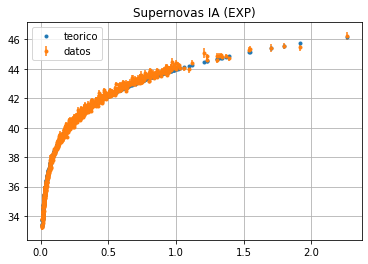

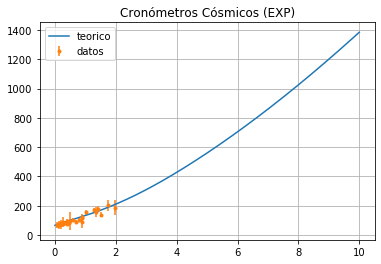

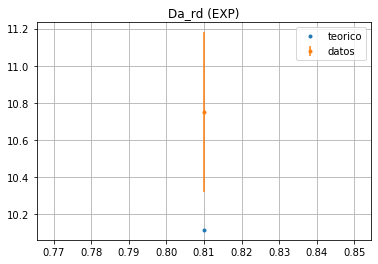

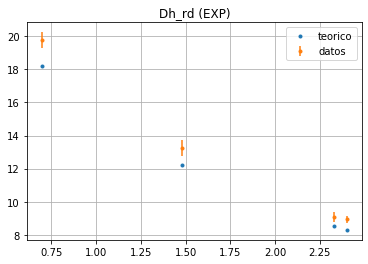

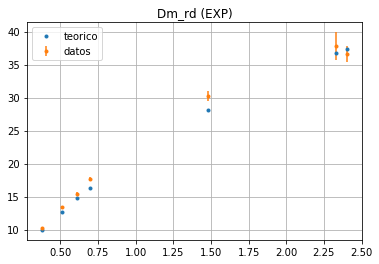

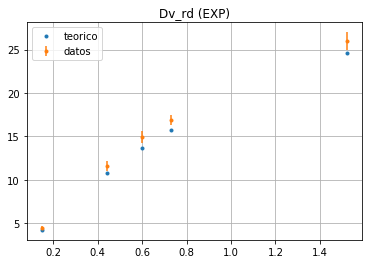

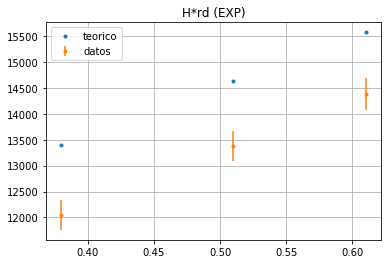

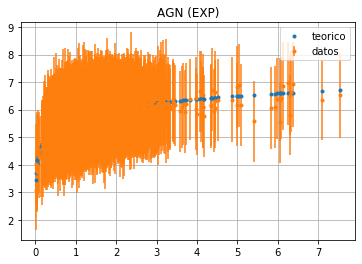

In [4]:
graficar_data([-19.35, 0.30,5, 69.22], _, index=4,
                dataset_SN = ds_SN,
                dataset_CC = ds_CC,
                dataset_BAO = ds_BAO,
                dataset_AGN = ds_AGN,
                model = 'EXP',
                close = False,
                ebeta = 1
                #, save_path = path_datos_global+'/plot_data'
                )